# Analysing data with Spark

A work by: Elliot Renel and Dorian Goepp.

## Downloading the data

Example command to download all the files for job events, running the downloads in parallel:

```bash
gsutil -m cp gs://clusterdata-2011-2/job_events/* ./job_events/
```

The parallelisation of the download is to take advantage of a high bandwidth internet connection. It would not help if the connection is slow.

As these are compressed with gzip, we need to un-compress them. There is an [easy way](https://stackoverflow.com/questions/16038087/extract-and-delete-all-gz-in-a-directory-linux) to do it for all files at once:

```bash
gunzip *.gz
```

> **Note:** As an afterthought, it might have been helpful to load the data directly from gzip files, saving some disk space at the cost of an increased computational load when a file is loaded.

## Parsing the schema file

The data we are working with is stored in CSV files of different "types", akin to tables in a relational database. Google provided a schema file (`schema.csv`) representing the fields of these CSV types.

To be able to make good use of the data, and to limit the risk of errors in selection of fields and handling of their format, we wrote a small python module to parse the schema file and help in loading and accessing the data in the CSV files.

In [1]:
# the Schema class of our utility module
from src.schema import Schema
# used to pretty-print tabular data
from tabulate import tabulate

Our module is used through an instance of the Schema class, as we will see later. The initialiser takes the path to the schema file provided by Google.

In [2]:
schema = Schema("data/schema.csv")

It is possible to print the object. This shows all the types of data in the data set. We commented the code block bellow as the output is quite verbose.

Note the `formatter` field. It is a function which will parse the input data and convert it to an appropriate Python type, based on the value in the `format` field of the schema.

In [3]:
# print(schema)

## Starting Spark

We use Spark locally, using all available cores.

In [4]:
from pyspark import SparkContext

# start spark with as many worker threads as available on the machine
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

23/01/15 17:21:17 WARN Utils: Your hostname, Kixus-k resolves to a loopback address: 127.0.1.1; using 192.168.1.29 instead (on interface enx3c2c30d47db5)
23/01/15 17:21:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/15 17:21:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Analysis on machine events (Q1 & Q2)

The machine events files describe events that occurred to the machines in the cluster, as well as their specifications (mostly in the initial events).

First, let us see the schema of this file's data:

In [5]:
print(
    tabulate(
        schema.get_table_fields(
            'machine_events', include_formatters=False), headers='keys'))

  field number  content      format       mandatory
--------------  -----------  -----------  -----------
             0  time         INTEGER      True
             1  machine ID   INTEGER      True
             2  event type   INTEGER      True
             3  platform ID  STRING_HASH  False
             4  CPUs         FLOAT        False
             5  Memory       FLOAT        False


Let us now load the data in a Spark RDD. The `load_rdd` method from Schema does this for us. We give it the name of a table, and it fetches the related CSV files (if any) from the eponym folder in `data/`, here `data/machine_events`.

In [6]:
machine_events = schema.load_rdd(sc, 'machine_events')

A small sample of the data, to have an idea of how it looks:

In [7]:
print(tabulate(
    machine_events.take(5),
    headers=schema.get_table_field_names('machine_events'),
    maxcolwidths=[None, None, None, 15, None, None]))

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             5             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             7             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            13             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy

The following will be used later to access fields of the data by their name instead of their index.

In [8]:
machine_events_get = schema.field_getters('machine_events')

### Distribution of CPU capacity (Q1)

We are looking for the distribution of machines according to their CPU capacity.

For this analysis, we only account for the machine creation events, and keep the latest such event for any given machine. The intent is to avoid registering any machine's CPU more than once, should it have been offline for some time.

Keeping the latest creation event is arbitrary, but considers that it is highly unlikely for a machine's CPU to be changed over time.

The first three operations on `machine_events` concern the extraction of machine creation events and the selection of one single creation event for any given machine.

The following three operations sums the numbers of machines with any given CPU capacity. We use the same method we were introduced to for words counting during the classes.

Distribution of machine capacity based on their CPU power (normalised):

In [9]:
from operator import add

cpu = machine_events_get['CPUs']
event_type = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda event: event_type(event) == 0 and cpu(event) is not None) \
    .map(lambda event: (machine_id(event), event)) \
    .reduceByKey(lambda r1, r2: r1 if time(r1) > time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage, nb in cpu_usage.collect():
    print(f"{nb} machines have CPU {usage}")

123 machines have CPU 0.25
11636 machines have CPU 0.5
796 machines have CPU 1.0


Here is a plot of the same data:

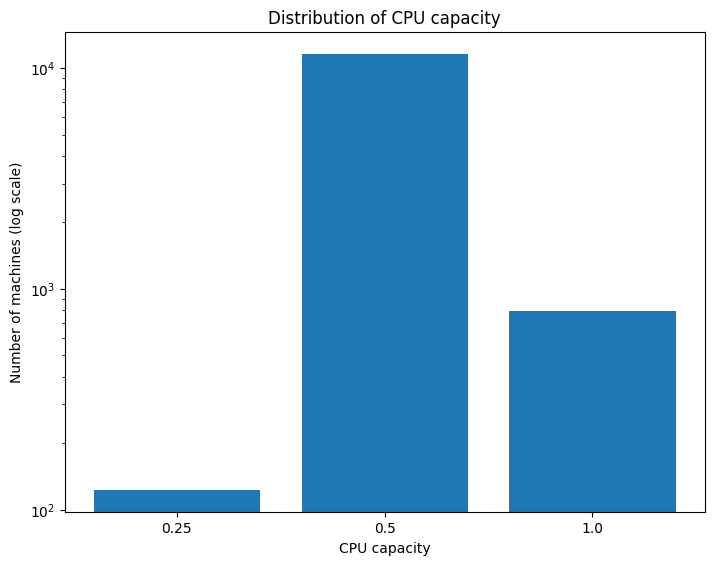

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
legend = cpu_usage.map(lambda x: str(
    x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend, count)

plt.xlabel("CPU capacity")
plt.ylabel("Number of machines (log scale)")
plt.title("Distribution of CPU capacity")

plt.yscale("log")
plt.show()

Please mind the y scale which is logarithmic, to better see the lesser frequent CPU capacities.

We observe that a vast majority of machines have half the maximum available CPU power. Less than ten times less machines have the full computational power and even less have a quarter of the maximal power.

### Lost Computational Power due to maintenance (Q2)

To begin with, we chose to interpret computational power as the product of CPU capacity with time. If the CPU capacity is a normalised version of CPU frequency, it means that such computational power represents a number of CPU cycles. Of course, two processors do not always perform the same number of instructions per cycle, but it is surely a good enough approximation for the task at hand.

This question requires that we study the story of each machine, namely when it was brought online and when it was put offline. So, as a first step, we create a new RDD where each element is a list of events regarding a machine.

To do so, we follow the map/reduce pattern. A last mapping operation removes the key-value mapping used for the map/reduce, as it is not needed later.

> **Note**: The latter operation might be a candidate for optimisation, should it become a bottleneck.

In [11]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row), row)) \
    .aggregateByKey(None, lambda acc, e: acc+[e] if acc is not None else [e], add) \
    .map(lambda machine: machine[1])

Let us have a preview of the resulting data, taking three entries of the RDD:

In [12]:
for a_story in machines_history.take(3):
    print(tabulate(
        a_story,
        headers=schema.get_table_field_names('machine_events'),
        maxcolwidths=[None, None, None, 15, None, None]))
    print('\n')

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=


         time    machine ID    event type  platform ID        CPUs    Memory
-------------  ------------  ------------  ---------------  ------  --------
            0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1306164355566            10             1  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1307163081914            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
       

And also see how many machines are covered in this sample data:

In [76]:
machines_history.count()

12583

During our exploration, we wondered whether the data was already sorted in the CSV source files by event time. The following counts the number of entries which are not sorted by time.

In [46]:
def to_event_times(history):
    """
    take the history of events for a machine (a list of events)
    and return the list of timestamps for these events, in the
    same order.
    """
    time_list = list()
    for event in history:
        time_list.append(machine_events_get['time'](event))
    return time_list


machines_history \
    .map(lambda events: to_event_times(events)) \
    .filter(lambda m: not sorted(m)) \
    .count()

0

The outcome is zero, showing that event entries are already sorted. The rest of our work on this question relies on this fact.

As the documentation for the data set states, the trace period starts at 600 seconds ($6 \times 10^{8} \mu s$). Therefore, to obtain the time of the end of the trace, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

> **Note:** This assumes the absence of records dated after the end of the trace period. For these, the time value would be $2^{63} - 1$ (MAXINT). We did not encounter this value.

In [47]:
from math import ceil

total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(
    f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2504935493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the theoretical total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. 

We assume that the CPU capacity of a machine never changes.

Also, there are some machines that have some cpu values at None, as shown below.

In [52]:
def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs.')

There are 32 machines with None values in their CPUs.


The events for these machines could be perfectly valid. For instance, it could be an update event which does not affect the CPU. However, there are so few machines affected that we consider it harmless to exclude them from further analysis.

We also want to know how much time the machine was off. To compute this, we look for add and remove machine events, considering the time between an add and a remove as active time and time during a remove and an add as off time.

> **Note:** We consider that a machine added after the start of the traces (time > 600s) has been added to the system at this point for the first time. Therefore, the time before its addition is not counted as lost computational power.

We have had to handle the special case where a machine is removed but not brought back before the end of the trace. Our tests showed at least 17% of machines were in this situation with our sample of the data. This required us to change the way we processed the data.

The function below does this processing for a given machine.

In [89]:
def lost_and_total_power(events):
    """
    Compute the time between installation of the machine (or start of the trace) and its final removal (or end of the trace). This also computes the sum of times the machine was offline between the two former time points.

    Then, these values are multiplied by the CPU capacity of the machine and returned as a tuple.
    """

    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    machine_off = True
    last_seen = None
    for event in events:
        if status(event) == 1 and not machine_off: # machine removed
            last_seen = time(event)
            machine_off = True
        elif status(event) == 0 and machine_off: # machine added
            machine_off = False
            if last_seen is not None:
                lost_time += time(event) - last_seen
    
    if machine_off and last_seen is not None:
        lost_time += total_trace_time + 6 * 10**8 - last_seen

    # Total time
    total_time = total_trace_time if (
        start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu, total_time*cpu)

The following keeps only machines which events all contain CPU information, and then applies the map/reduce scheme to compute the total and lost computational power.

In [91]:
power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')

During the trace time, around 0.6836% of the computational power was lost.
The exact percentage obtained is 0.6836169046693634% !


The lost computational power we obtained for the first sample of data is ≈0.68%, which seems to be quite an achievement.

## Distribution of jobs and tasks per scheduling class (Q3)

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer than tasks, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [131]:
print(
    tabulate(
        schema.get_table_fields('job_events', include_formatters=False),
        headers='keys',
        maxcolwidths=40))

  field number  content           format       mandatory
--------------  ----------------  -----------  -----------
             0  time              INTEGER      True
             1  missing info      INTEGER      False
             2  job ID            INTEGER      True
             3  event type        INTEGER      True
             4  user              STRING_HASH  False
             5  scheduling class  INTEGER      False
             6  job name          STRING_HASH  False
             7  logical job name  STRING_HASH  False


Firstly, we gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [93]:
job_events = schema.load_rdd(sc,'job_events')
job_events_get = schema.field_getters('job_events')

An overview of the data, which we can unfortunately not tabulate because its content is too wide:

In [116]:
job_events.take(2)

[[1759537643559,
  None,
  6416951808,
  0,
  '68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4=',
  2,
  'hsNjJ1kuW0Fjw19LCKSNMoIedO6dXEwotcAwuZzN+W8=',
  'tjDJ4Yi7F2TEXAS8aMiOSj0Gnf0fMQU71fbn4Hh7YaQ='],
 [1759537651487,
  None,
  6416951928,
  0,
  'CyS0bJ1mSJjSSGuoHDUH9h1P9aCRWvC13/GWBPTKDWw=',
  2,
  'BsI3s4eBz40Sw71oIDYmHa97gITSve44lxrA1wfeE80=',
  'XJDU79m2icgPfbSC3t76/jDJ852+gvKUykoSUdjFzBo=']]

In [119]:
print(f"There are {job_events.count()} job events.")

There are 2012242 job events.


On Dorian's machine, the computation above took 46s (with other running jobs such as browser and synchronisation service).

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [121]:
# event type 0 = SUBMIT
submit_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0) \
    .cache()

The documentation says that it is possible for a job to be submitted more than once, when it has been evicted, killed or when it failed but still is runnable (up to a maximal number of trials).

What if the the scheduling class had been changed when the job is submitted another time?

In [126]:
jobs_with_several_scheduling_classes = submit_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            {job_events_get['scheduling class'](job_event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(f'{jobs_with_several_scheduling_classes}')

0


None.

> **Note:** observe the syntax used in `map` and `reduceByKey` above. We used python sets, which allow us to count all *distinct* scheduling classes a job was given.

Let us then proceed with gathering the scheduling classes.

In [143]:
job_scheduling_classes = submit_events \
    .map(lambda event: (job_events_get['job ID'](event), 
                        job_events_get['scheduling class'](event))) \
    .distinct() \
    .map(lambda job_class: (job_class[1], 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in job_scheduling_classes:
    print(scheduling_class)

(0, 257275)
(1, 215109)
(2, 194513)
(3, 5177)


To better understand these values, let us plot them:

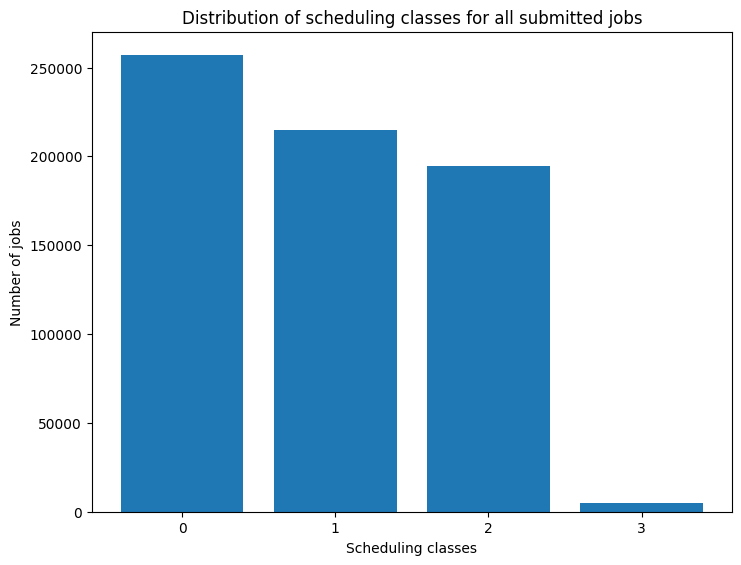

In [147]:
def bar_plot_question3(scheduling_classes, title, type):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    scheduling_class = list(map(lambda x: x[0], scheduling_classes))
    count = list(map(lambda x: x[1], scheduling_classes))
    ax.bar(scheduling_class, count)
    plt.xlabel("Scheduling classes")
    plt.ylabel(f"Number of {type}")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()


bar_plot_question3(job_scheduling_classes,
                   "Distribution of scheduling classes for all submitted jobs", "jobs")

As a reminder, the scheduling class 3 is the most latency sensitive and 0 the least. The vast majority of jobs are of non-critical latency sensitivity, the more sensitive, the lesser the number.

It should be good, as insensitive jobs can be scheduled when the sensitive ones are not running, but do not suffer from being put aside when sensitive jobs have to take over. This should help maximising resource usage.

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [132]:
task_events_get = schema.field_getters('task_events')

print(
    tabulate(
        schema.get_table_fields('task_events', include_formatters=False),
        headers='keys',
        maxcolwidths=[None, 20, None, None, 40]))

  field number  content             format       mandatory
--------------  ------------------  -----------  -----------
             0  time                INTEGER      True
             1  missing info        INTEGER      False
             2  job ID              INTEGER      True
             3  task index          INTEGER      True
             4  machine ID          INTEGER      False
             5  event type          INTEGER      True
             6  user                STRING_HASH  False
             7  scheduling class    INTEGER      False
             8  priority            INTEGER      True
             9  CPU request         FLOAT        False
            10  memory request      FLOAT        False
            11  disk space request  FLOAT        False
            12  different machines  BOOLEAN      False
                restriction


Then, we load the data and filter for submission events.

In [135]:
task_events = schema.load_rdd(sc,'task_events').persist()

task_submit_events = task_events \
    .filter(lambda task_event: task_events_get['event type'](task_event) == 0) \
    .cache()

A sample of this data:

In [136]:
for task_event in task_submit_events.take(5):
    print(task_event)

# This version is prettier, but too wide for some screens.
# print(
#     tabulate(
#         task_submit_events.take(5),
#         headers=schema.get_table_field_names('task_events'),
#         maxcolwidths=[None, None, None, None, None, None, 10]))

[0, 2, 3418309, 0, 4155527081, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, 2, 3418309, 1, 329150663, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, None, 3418314, 0, 3938719206, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, None, 3418314, 1, 351618647, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, 2, 3418319, 0, 431052910, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]


Following the same idea as for jobs, let us count how many tasks have been submitted more than once within different scheduling classes.

> **Note:** that here and after, we use a tuple as the key representing a task. Indeed, each task is represented by the job it belongs to and its task index. It does not have a unique identifier of its own.

In [20]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

0 tasks have more than one scheduling class.


From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

On to the distribution of scheduling classes:

In [138]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

(2, 47599)
(0, 98066)
(3, 28192)
(1, 27634)


In [141]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        task_events_get['scheduling class'](event))) \
    .distinct() \
    .map(lambda task_class: (task_class[1], 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

(2, 41873)
(0, 94244)
(3, 28110)
(1, 26699)


And the related plot, featuring both jobs and tasks:

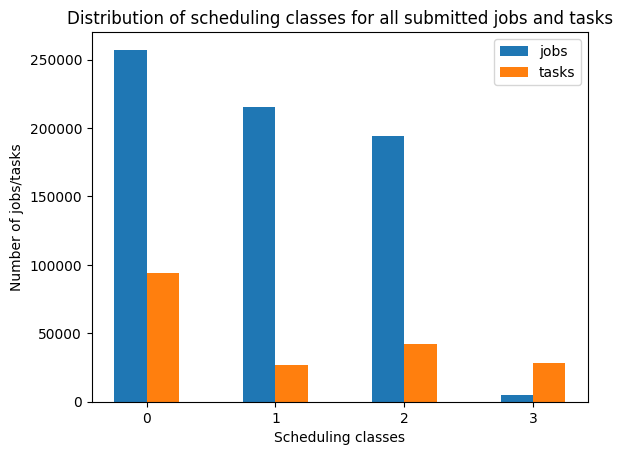

In [190]:
classes = range(0, 4)
w = 0.25

# Plotting jobs
scheduling_class = list(map(lambda x: (x[0] - w/2), job_scheduling_classes))
count = list(map(lambda x: x[1], job_scheduling_classes))
plt.bar(scheduling_class, count, width=w, align='center', label="jobs")

# Plotting tasks
scheduling_class = list(map(lambda x: x[0] + w/2, task_scheduling_classes))
count = list(map(lambda x: x[1], task_scheduling_classes))
plt.bar(scheduling_class, count, width=w, align='center', label="tasks")

plt.xlabel("Scheduling classes")
plt.ylabel("Number of jobs/tasks")
plt.xticks(classes, [str(a_class) for a_class in classes])
plt.title("Distribution of scheduling classes for all submitted jobs and tasks")
plt.legend()
plt.show()

This plot seems counter-intuitive. I suspect that we might need to process all the data for a more comprehensive view.

## Relation between scheduling class and eviction of tasks (Q4)

We now focus on events of type 2, namely eviction events. Using the usual map/reduce pattern to count occurrences of a value, we gather the evictions per scheduling class.

In [192]:
scheduling_eviction_relations = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0]) \
    .collect()

for relations in scheduling_eviction_relations:
    print(relations)

(0, 2864)
(1, 792)
(2, 662)
(3, 20)


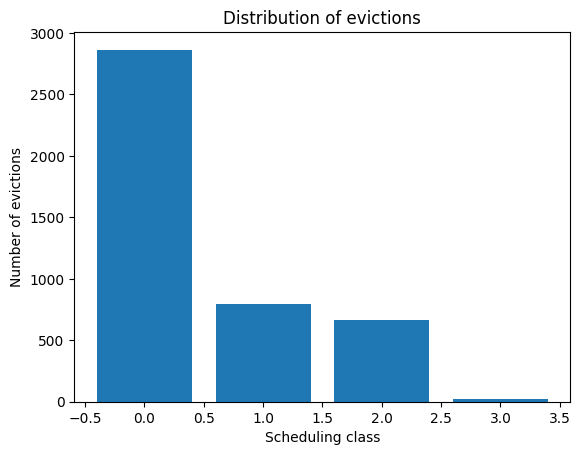

In [198]:
fig = plt.figure()

legend = list(map(lambda x: x[0], scheduling_eviction_relations))
count = list(map(lambda x: x[1], scheduling_eviction_relations))
plt.bar(legend, count)

plt.xlabel("Scheduling class")
plt.ylabel("Number of evictions")
plt.title("Distribution of evictions")

plt.show()

Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.